<a href="https://colab.research.google.com/github/budhiacharya/AI-Lesson/blob/main/Assignment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 8: Supervised Learning Classification

 Dataset: I choose iris dataset from scikit-learn

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning libraries
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
                             RocCurveDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

Task 1: Dataset Selection and Preprocessing


In [3]:
# Loading the dataset
# From scikit-learn
data = load_iris(as_frame=True)
df = data.frame.copy()                 # features and target
df.rename(columns={'target': 'label'}, inplace=True)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
# Dataset info
df.info()
# Check for missing values
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   label              150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


,0
sepal length (cm),0
sepal width (cm),0
petal length (cm),0
petal width (cm),0
label,0


In [5]:
# Clean (Iris is already clean)
df = df.drop_duplicates().reset_index(drop=True)

In [6]:
# Features / Target
X = df.drop(columns=['label'])
y = df['label']                        # 0=setosa, 1=versicolor, 2=virginica
class_names = data.target_names        # for display

In [7]:
# Train/test split (stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# Scale for models that need it (LogReg, KNN). RF doesn't need scaling.
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

Task 2: Exploratory Data Analysis (EDA):

In [9]:
print("Shape:", df.shape)
print("\nClass distribution (counts):")
print(y.value_counts().sort_index().rename(index=dict(enumerate(class_names))))

Shape: (149, 5)

Class distribution (counts):
label
setosa        50
versicolor    50
virginica     49
Name: count, dtype: int64


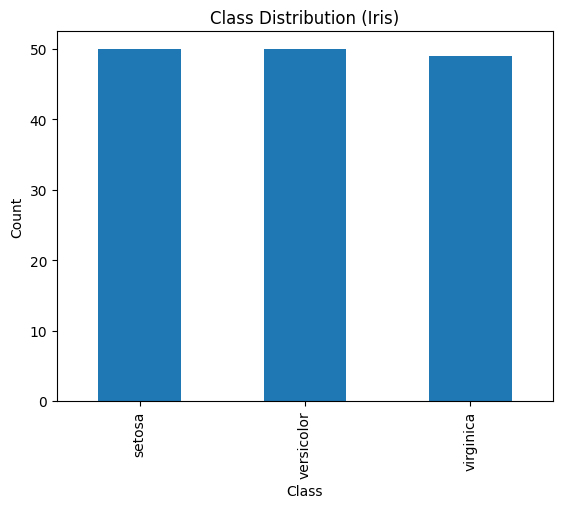

In [10]:
# Plot class distribution
(pd.Series(y)
   .map(dict(enumerate(class_names)))
   .value_counts()[class_names]               # keep consistent order
   .plot(kind='bar', title='Class Distribution (Iris)'))
plt.xlabel('Class'); plt.ylabel('Count')
plt.show()

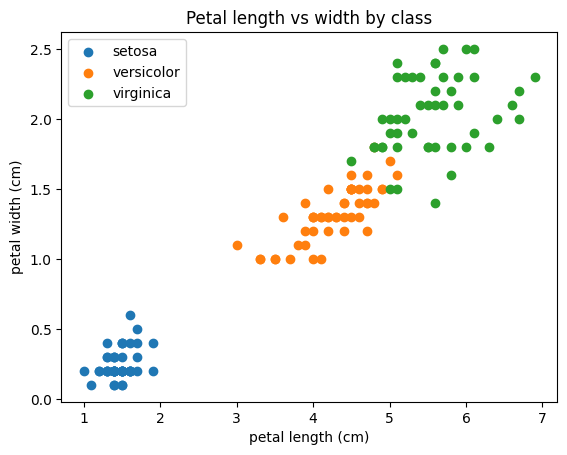

In [11]:
# Simple 2D scatter: petal length vs petal width
plt.title("Petal length vs width by class")
for k, name in enumerate(class_names):
    subset = df[df['label'] == k]
    plt.scatter(subset['petal length (cm)'], subset['petal width (cm)'], label=name)
plt.xlabel('petal length (cm)'); plt.ylabel('petal width (cm)')
plt.legend(); plt.show()

Task 3: Model Implementation and Evaluation:

In [13]:
from sklearn.preprocessing import label_binarize
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7)
}

rows = []
y_test_bin = label_binarize(y_test, classes=[0,1,2])  # for multiclass ROC-AUC

for name, model in models.items():
    # Use scaled features for LogReg/KNN; RF can use unscaled
    if name in ["LogisticRegression", "KNN"]:
        model.fit(X_train_sc, y_train)
        y_pred = model.predict(X_test_sc)
        y_score = (model.predict_proba(X_test_sc)
                   if hasattr(model, "predict_proba") else None)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_score = (model.predict_proba(X_test)
                   if hasattr(model, "predict_proba") else None)

    acc  = accuracy_score(y_test, y_pred)
    # Use macro averaging for multiclass to treat classes equally
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1   = f1_score(y_test, y_pred, average='macro')

    # Multiclass ROC-AUC (macro OVR) if scores available
    if y_score is not None:
        auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr', average='macro')
    else:
        auc = np.nan

    rows.append([name, acc, prec, rec, f1, auc])

res_df = pd.DataFrame(rows, columns=["Model", "Accuracy", "Precision(macro)", "Recall(macro)", "F1(macro)", "ROC_AUC(macro-OVR)"])
print("\n=== Test Performance ===")
print(res_df.sort_values(by="ROC_AUC(macro-OVR)", ascending=False))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Test Performance ===
                Model  Accuracy  Precision(macro)  Recall(macro)  F1(macro)  \
2                 KNN  0.966667          0.969697       0.966667   0.966583   
1        RandomForest  0.933333          0.933333       0.933333   0.933333   
0  LogisticRegression  0.866667          0.872727       0.866667   0.868170   

   ROC_AUC(macro-OVR)  
2            1.000000  
1            0.985000  
0            0.978333  


Task 4: Model Interpretation and Inference:

In [14]:
best_name = res_df.sort_values(by="ROC_AUC(macro-OVR)", ascending=False).iloc[0]["Model"]
print(f"\nBest model by ROC_AUC (macro-OVR): {best_name}")

best_model = models[best_name]
use_scaled = best_name in ["LogisticRegression", "KNN"]
Xts = X_test_sc if use_scaled else X_test


Best model by ROC_AUC (macro-OVR): KNN


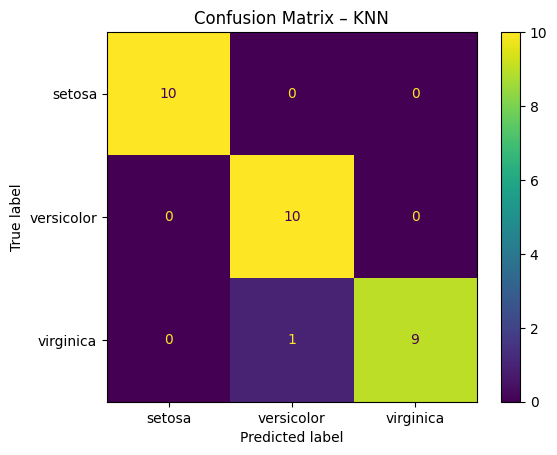

In [15]:
# Confusion matrix
y_pred_best = best_model.predict(Xts)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format='d')
plt.title(f"Confusion Matrix – {best_name}")
plt.show()

<Figure size 640x480 with 0 Axes>

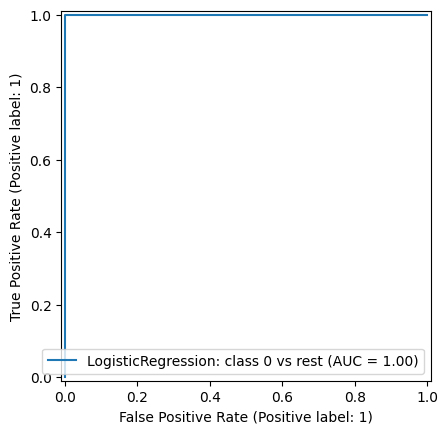

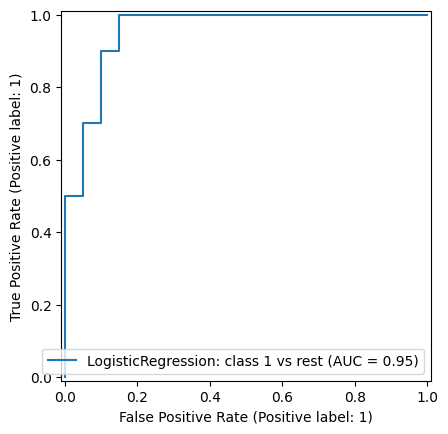

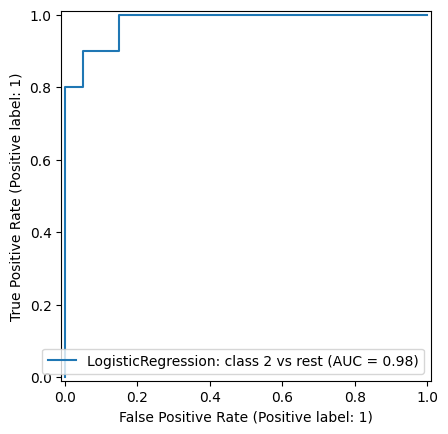

<Figure size 640x480 with 0 Axes>

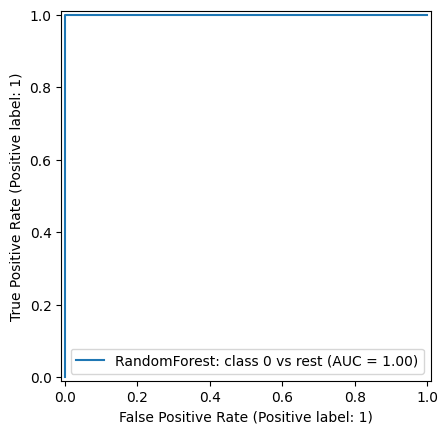

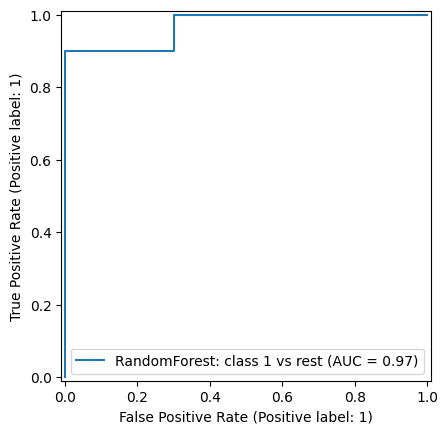

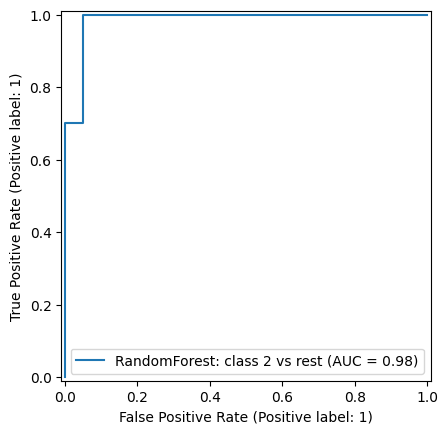

<Figure size 640x480 with 0 Axes>

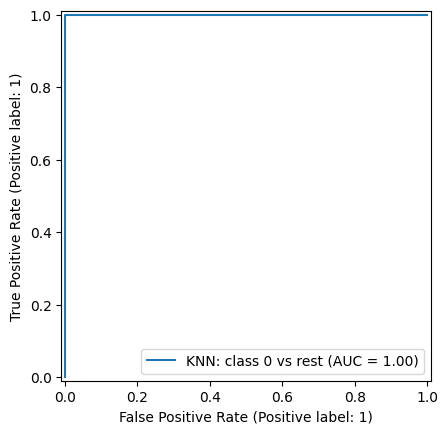

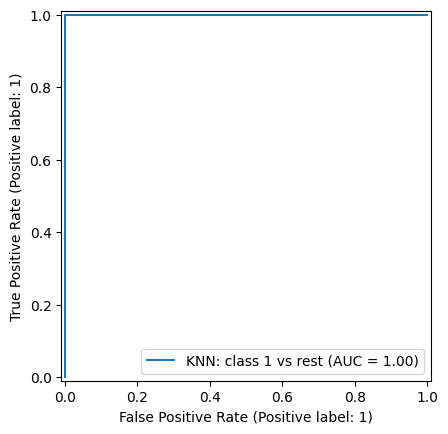

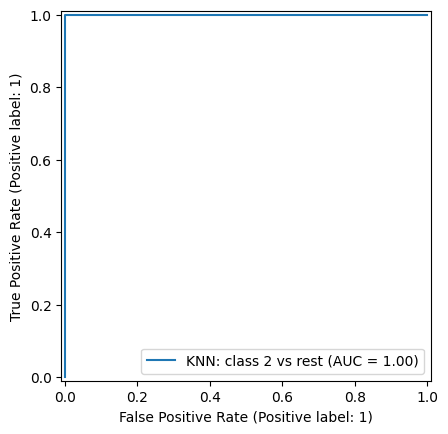

In [17]:
# ROC curves (one-vs-rest) for each model
from sklearn.metrics import RocCurveDisplay, roc_curve
for name, model in models.items():
    # pick scaled/unscaled features consistently with how you trained
    Xts_local = X_test_sc if name in ["LogisticRegression", "KNN"] else X_test

    if not hasattr(model, "predict_proba"):
        print(f"Skipping ROC for {name} (no predict_proba).")
        continue

    # make sure class order in y_score matches the binarized columns
    classes = model.classes_
    y_score = model.predict_proba(Xts_local)                  # shape: (n_samples, n_classes)
    y_test_bin = label_binarize(y_test, classes=classes)      # shape: (n_samples, n_classes)

    # plot one figure per model with OVR curves
    plt.figure()
    for i, cls in enumerate(classes):
        RocCurveDisplay.from_predictions(
            y_true=y_test_bin[:, i],
            y_pred=y_score[:, i],
            name=f"{name}: class {cls} vs rest")

Task 5: Deployment and Monitoring:

In [20]:
print("""
Deployment (high-level plan):
1) Save the trained best model (pickle/joblib) along with the scaler and feature list.
2) Create a tiny FastAPI/Flask service with a /predict endpoint.
3) Containerize (Docker) and deploy (Cloud Run / App Service / EC2).
4) Validate inputs (pydantic) and log predictions + timings.

Monitoring:
- Track data drift vs. training distributions (simple stats or tools like Evidently).
- Track rolling Accuracy/Precision/Recall/F1 once ground-truth arrives.
- Watch latency and error rates; alert on anomalies.

Real-time handling:
- Keep the exact same preprocessing (feature order + scaler).
- Batch vs. streaming scoring depending on use case.
""")


Deployment (high-level plan):
1) Save the trained best model (pickle/joblib) along with the scaler and feature list.
2) Create a tiny FastAPI/Flask service with a /predict endpoint.
3) Containerize (Docker) and deploy (Cloud Run / App Service / EC2).
4) Validate inputs (pydantic) and log predictions + timings.

Monitoring:
- Track data drift vs. training distributions (simple stats or tools like Evidently).
- Track rolling Accuracy/Precision/Recall/F1 once ground-truth arrives.
- Watch latency and error rates; alert on anomalies.

Real-time handling:
- Keep the exact same preprocessing (feature order + scaler).
- Batch vs. streaming scoring depending on use case.



In [21]:
# 6) Save artifact (for deployment demo)
# ---------------------------------------------------------
import joblib
artifact = {
    "model_name": best_name,
    "model": best_model,
    "scaler": scaler,
    "features": X.columns.tolist(),
    "class_names": class_names.tolist()
}
joblib.dump(artifact, "best_iris_model.joblib")
print("Saved: best_iris_model.joblib")

Saved: best_iris_model.joblib
